# Replicating plots in [*Rangaraju et al.*](http://dx.doi.org/10.7554/eLife.08833).

Tong Shu Li

We demonstrate the capabilities of our drift plotting functions. To do so, we will try to replicate some figures from [*Rangaraju et al.*](http://dx.doi.org/10.7554/eLife.08833).

In [1]:
import pandas as pd
import random
import sys

In [2]:
sys.path.append("..")

In [3]:
from src.plots import plot_p_val_heatmap
from src.plots import plot_drift
from src.plots import plot_drift_split_box

from src.util import subset

In [4]:
%matplotlib inline

---

## Read the averaged drift data

In [5]:
data = pd.read_csv("../data/worms_mianserin/avg_annotated_cpm_values.tsv", sep = '\t')

In [6]:
data.shape

(130548, 11)

In [7]:
data.head()

,seqname,sample,value,day_harvested,drug_conc_uM,day_drug_added,youngref,trans_drift,drug,wormbaseid,gene_symbol
0,2RSSE.1,1,4.105727,1,0,1,4.105726,-0.012915,water,WBGene00007064,2RSSE.1
1,2RSSE.1,2,7.687213,3,0,1,4.105726,0.562429,water,WBGene00007064,2RSSE.1
2,2RSSE.1,3,7.220500,5,0,1,4.105726,0.562490,water,WBGene00007064,2RSSE.1
3,2RSSE.1,4,3.923197,10,0,1,4.105726,-0.049039,water,WBGene00007064,2RSSE.1
4,2RSSE.1,5,4.042023,3,50,1,4.105726,-0.030335,mianserin,WBGene00007064,2RSSE.1


---

## Plot drift for all genes in water treated worms at different days of age

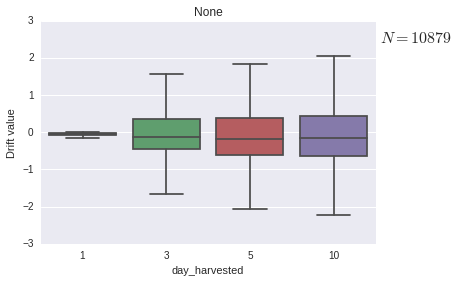

In [8]:
temp = data.query("drug == 'water'")
                  
plot_drift(
    "box", temp,
    "day_harvested", "trans_drift", "seqname"
)

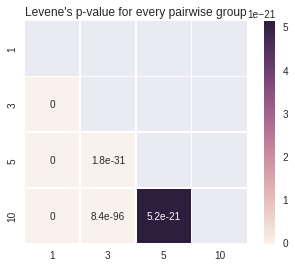

In [9]:
plot_p_val_heatmap(temp, "day_harvested", "trans_drift")

## Plot drift for water and drug worms treated at day 1

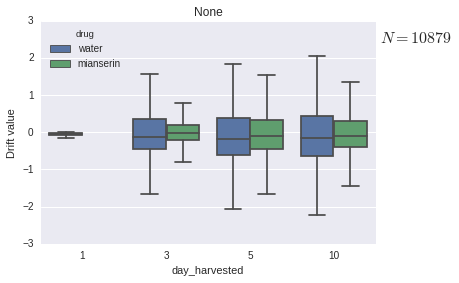

In [10]:
temp = data.query("day_drug_added == 1 & drug_conc_uM in(0, 50)")

plot_drift(
    "box", temp, "day_harvested", "trans_drift", "seqname",
    groupby = "drug"
)

/home/toby/Research/Projects/ageing/venv/lib64/python3.4/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


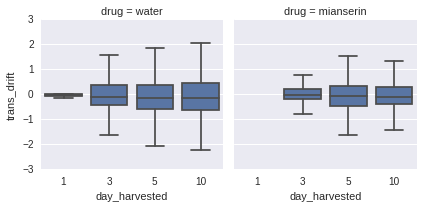

In [11]:
plot_drift_split_box(
    temp, "day_harvested", "trans_drift", "drug"
)

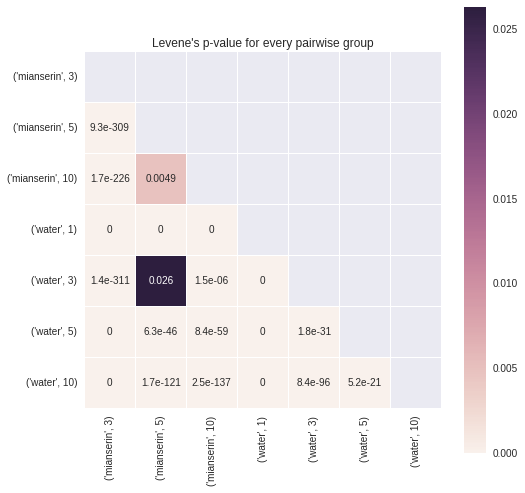

In [12]:
plot_p_val_heatmap(
    temp, ["drug", "day_harvested"], "trans_drift",
    rc = {"figure.figsize": (8, 8)}
)

## Drift for mianserin added on different days

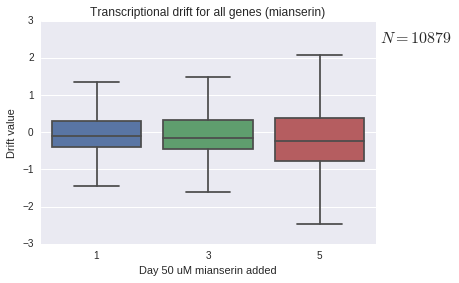

In [13]:
temp = subset(
    {
        "drug": ["mianserin"],
        "drug_conc_uM": 50,
        "day_harvested": 10
    },
    data
)

res = plot_drift(
    "box", temp, "day_drug_added", "trans_drift", "seqname",
    title = "Transcriptional drift for all genes (mianserin)"
)

res.set_xlabel("Day 50 uM mianserin added")

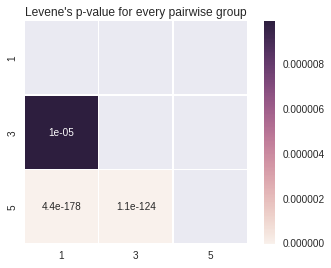

In [14]:
plot_p_val_heatmap(temp, ["day_drug_added"], "trans_drift")